In [1]:
import os
import numpy as np
import cv2
import imageio.v3 as imageio
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import jax
from jax import numpy as jnp
from flax import nnx
import orbax.checkpoint as ocp
from net import RubbishClassifier
from tqdm import tqdm

In [13]:
from matplotlib import pyplot as plt
import matplotlib

plt.rcParams["font.family"] = "LXGW WenKai Mono"

In [2]:
def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)
    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)
    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios
    # Ensure dw and dh are positive and can fill to new_shape
    dw = new_shape[1] - new_unpad[0] if dw < 0 else dw
    dh = new_shape[0] - new_unpad[1] if dh < 0 else dh
    dw /= 2  # divide padding into 2 sides
    dh /= 2
    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, ratio, (dw, dh)

In [3]:
# 定义类别名称
class_names = [
    'battery', 'biological', 'brown-glass', 'cardboard', 
    'clothes', 'green-glass', 'metal', 'paper', 
    'plastic', 'shoes', 'trash', 'white-glass'
]

print(f"类别数量: {len(class_names)}")
print(f"类别列表: {class_names}")

# 加载训练好的模型
abstract_model = nnx.eval_shape(lambda: RubbishClassifier(num_classes=12, rngs=nnx.Rngs(0)))
graphdef, abstract_state = nnx.split(abstract_model)

with ocp.CheckpointManager(
    os.path.join(os.getcwd(), "checkpoints/"),
    options=ocp.CheckpointManagerOptions(max_to_keep=1),
) as mngr:
    if mngr.latest_step() is not None:
        state = mngr.restore(mngr.latest_step(), args=ocp.args.StandardRestore(abstract_state))
        model = nnx.merge(graphdef, state)
        print(f"成功加载模型，checkpoint步数: {mngr.latest_step()}")
    else:
        print("未找到训练好的模型，请先训练模型")



类别数量: 12
类别列表: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']
成功加载模型，checkpoint步数: 10000
成功加载模型，checkpoint步数: 10000


/home/pdch/miniconda3/envs/jax/lib/python3.12/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1251: UserWarning: Sharding info not provided when restoring. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


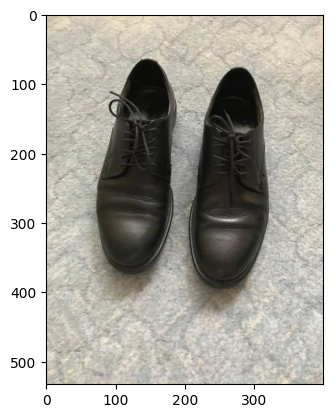

Image shape: (533, 400, 3)


In [6]:
image_path = "./data/garbage_classification/shoes/shoes1.jpg"
img = imageio.imread(image_path)
# Display the image using matplotlib
plt.imshow(img)
plt.show()

# print the shape of the image
print("Image shape:", img.shape)

In [7]:
# 图像预处理
img_processed, _, _ = letterbox(img, new_shape=(224, 224), auto=False)
img_normalized = (img_processed / 255.0).astype(np.float32)  # 归一化
img_batch = np.expand_dims(img_normalized, axis=0)  # 添加batch维度

# 模型推理
logits = model(img_batch)
probabilities = jax.nn.softmax(logits, axis=-1)

# 获得预测结果
predicted_class = int(jnp.argmax(probabilities, axis=-1)[0])
max_probability = float(jnp.max(probabilities, axis=-1)[0])

print(f"预测类别: {class_names[predicted_class]} (类别ID: {predicted_class})")
print(f"置信度: {max_probability:.4f} ({max_probability*100:.2f}%)")

# 显示Top 5预测结果
print(f"\nTop 5 predictions:")
top5_indices = jnp.argsort(probabilities[0])[-5:][::-1]  # 降序排列
for i, idx in enumerate(top5_indices):
    idx = int(idx)
    prob = float(probabilities[0][idx])
    print(f"{i+1}. {class_names[idx]:<12}: {prob:.4f} ({prob*100:.2f}%)")

预测类别: shoes (类别ID: 9)
置信度: 0.6410 (64.10%)

Top 5 predictions:
1. shoes       : 0.6410 (64.10%)
2. clothes     : 0.2545 (25.45%)
3. battery     : 0.0606 (6.06%)
4. paper       : 0.0169 (1.69%)
5. metal       : 0.0085 (0.85%)


## 验证集完整评估

加载验证集数据并进行全面的模型性能评估

In [8]:
def load_validation_data(data_path="./data"):
    """加载验证集数据"""
    try:
        # 加载验证集
        val_images = np.load(os.path.join(data_path, "val_images.npy"), mmap_mode='r')
        val_labels = np.load(os.path.join(data_path, "val_labels.npy"), mmap_mode='r')
        
        print(f"验证集加载成功:")
        print(f"  图片数量: {val_images.shape[0]}")
        print(f"  图片尺寸: {val_images.shape[1:]}")
        print(f"  标签数量: {val_labels.shape[0]}")
        print(f"  标签范围: {val_labels.min()} - {val_labels.max()}")
        
        return val_images, val_labels
    except FileNotFoundError as e:
        print(f"验证集文件未找到: {e}")
        print("请先运行数据处理notebook生成验证集文件")
        return None, None

# 加载验证集
val_images, val_labels = load_validation_data()

if val_images is not None:
    # 显示验证集中各类别的分布
    unique_labels, counts = np.unique(val_labels, return_counts=True)
    print(f"\n验证集类别分布:")
    for label, count in zip(unique_labels, counts):
        print(f"  {class_names[label]:<12}: {count:4d} 张 ({count/len(val_labels)*100:.1f}%)")

验证集加载成功:
  图片数量: 2328
  图片尺寸: (224, 224, 3)
  标签数量: 2328
  标签范围: 0 - 11

验证集类别分布:
  battery     :  142 张 (6.1%)
  biological  :  148 张 (6.4%)
  brown-glass :   91 张 (3.9%)
  cardboard   :  134 张 (5.8%)
  clothes     :  799 张 (34.3%)
  green-glass :   94 张 (4.0%)
  metal       :  115 张 (4.9%)
  paper       :  157 张 (6.7%)
  plastic     :  130 张 (5.6%)
  shoes       :  297 张 (12.8%)
  trash       :  105 张 (4.5%)
  white-glass :  116 张 (5.0%)


In [9]:
def predict_batch(model, images, batch_size=32):
    """批量预测图片"""
    predictions = []
    probabilities_all = []
    
    num_batches = (len(images) + batch_size - 1) // batch_size
    
    print(f"开始批量预测，共 {len(images)} 张图片，分 {num_batches} 个批次")
    
    for i in tqdm(range(0, len(images), batch_size), desc="预测进度"):
        batch_images = images[i:i+batch_size]
        
        # 模型推理
        logits = model(batch_images)
        probs = jax.nn.softmax(logits, axis=-1)
        preds = jnp.argmax(logits, axis=-1)
        
        predictions.extend(preds.tolist())
        probabilities_all.extend(probs.tolist())
    
    return np.array(predictions), np.array(probabilities_all)

# 进行批量预测
if val_images is not None and val_labels is not None:
    print("\\n开始对验证集进行预测...")
    predictions, probabilities = predict_batch(model, val_images, batch_size=64)
    
    print(f"预测完成!")
    print(f"预测结果形状: {predictions.shape}")
    print(f"概率矩阵形状: {probabilities.shape}")

\n开始对验证集进行预测...
开始批量预测，共 2328 张图片，分 37 个批次


预测进度: 100%|██████████| 37/37 [00:42<00:00,  1.14s/it]

预测完成!
预测结果形状: (2328,)
概率矩阵形状: (2328, 12)


### 1. 基础性能指标

In [10]:
if val_images is not None and val_labels is not None:
    # 计算基础指标
    accuracy = accuracy_score(val_labels, predictions)
    
    # 计算各类别的精确率、召回率、F1分数
    precision_macro = precision_score(val_labels, predictions, average='macro', zero_division=0)
    recall_macro = recall_score(val_labels, predictions, average='macro', zero_division=0)
    f1_macro = f1_score(val_labels, predictions, average='macro', zero_division=0)
    
    precision_weighted = precision_score(val_labels, predictions, average='weighted', zero_division=0)
    recall_weighted = recall_score(val_labels, predictions, average='weighted', zero_division=0)
    f1_weighted = f1_score(val_labels, predictions, average='weighted', zero_division=0)
    
    print("=" * 60)
    print("模型性能评估结果")
    print("=" * 60)
    print(f"整体准确率 (Accuracy):        {accuracy:.4f} ({accuracy*100:.2f}%)")
    print()
    print("宏平均 (Macro Average):")
    print(f"  精确率 (Precision):        {precision_macro:.4f}")
    print(f"  召回率 (Recall):           {recall_macro:.4f}")
    print(f"  F1分数 (F1-Score):         {f1_macro:.4f}")
    print()
    print("加权平均 (Weighted Average):")
    print(f"  精确率 (Precision):        {precision_weighted:.4f}")
    print(f"  召回率 (Recall):           {recall_weighted:.4f}")
    print(f"  F1分数 (F1-Score):         {f1_weighted:.4f}")
    print("=" * 60)

模型性能评估结果
整体准确率 (Accuracy):        0.8406 (84.06%)

宏平均 (Macro Average):
  精确率 (Precision):        0.8032
  召回率 (Recall):           0.8144
  F1分数 (F1-Score):         0.8069

加权平均 (Weighted Average):
  精确率 (Precision):        0.8446
  召回率 (Recall):           0.8406
  F1分数 (F1-Score):         0.8413


### 2. 详细分类报告

In [11]:
if val_images is not None and val_labels is not None:
    # 生成详细的分类报告
    print("\\n详细分类报告:")
    print("=" * 80)
    
    # 计算每个类别的指标
    precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
        val_labels, predictions, average=None, zero_division=0
    )
    
    # 创建表格式报告
    print(f"{'类别':<12} {'精确率':<8} {'召回率':<8} {'F1分数':<8} {'支持数':<8} {'样本数':<8}")
    print("-" * 80)
    
    for i, class_name in enumerate(class_names):
        if i < len(precision_per_class):
            class_count = np.sum(val_labels == i)
            print(f"{class_name:<12} {precision_per_class[i]:<8.3f} {recall_per_class[i]:<8.3f} "
                  f"{f1_per_class[i]:<8.3f} {support_per_class[i]:<8} {class_count:<8}")
    
    print("-" * 80)
    print(f"{'宏平均':<12} {precision_macro:<8.3f} {recall_macro:<8.3f} {f1_macro:<8.3f} "
          f"{len(val_labels):<8} {len(val_labels):<8}")
    print(f"{'加权平均':<12} {precision_weighted:<8.3f} {recall_weighted:<8.3f} {f1_weighted:<8.3f} "
          f"{len(val_labels):<8} {len(val_labels):<8}")
    
    # 使用sklearn的分类报告
    print("\\n\\nSklearn分类报告:")
    print("=" * 80)
    report = classification_report(val_labels, predictions, target_names=class_names, 
                                 digits=4, zero_division=0)
    print(report)

\n详细分类报告:
类别           精确率      召回率      F1分数     支持数      样本数     
--------------------------------------------------------------------------------
battery      0.836    0.789    0.812    142      142     
biological   0.801    0.899    0.847    148      148     
brown-glass  0.875    0.846    0.860    91       91      
cardboard    0.882    0.836    0.858    134      134     
clothes      0.953    0.919    0.936    799      799     
green-glass  0.882    0.957    0.918    94       94      
metal        0.680    0.722    0.700    115      115     
paper        0.814    0.892    0.851    157      157     
plastic      0.681    0.754    0.715    130      130     
shoes        0.774    0.751    0.762    297      297     
trash        0.664    0.771    0.714    105      105     
white-glass  0.796    0.638    0.708    116      116     
--------------------------------------------------------------------------------
宏平均          0.803    0.814    0.807    2328     2328    
加权平均         0.8

### 3. 混淆矩阵

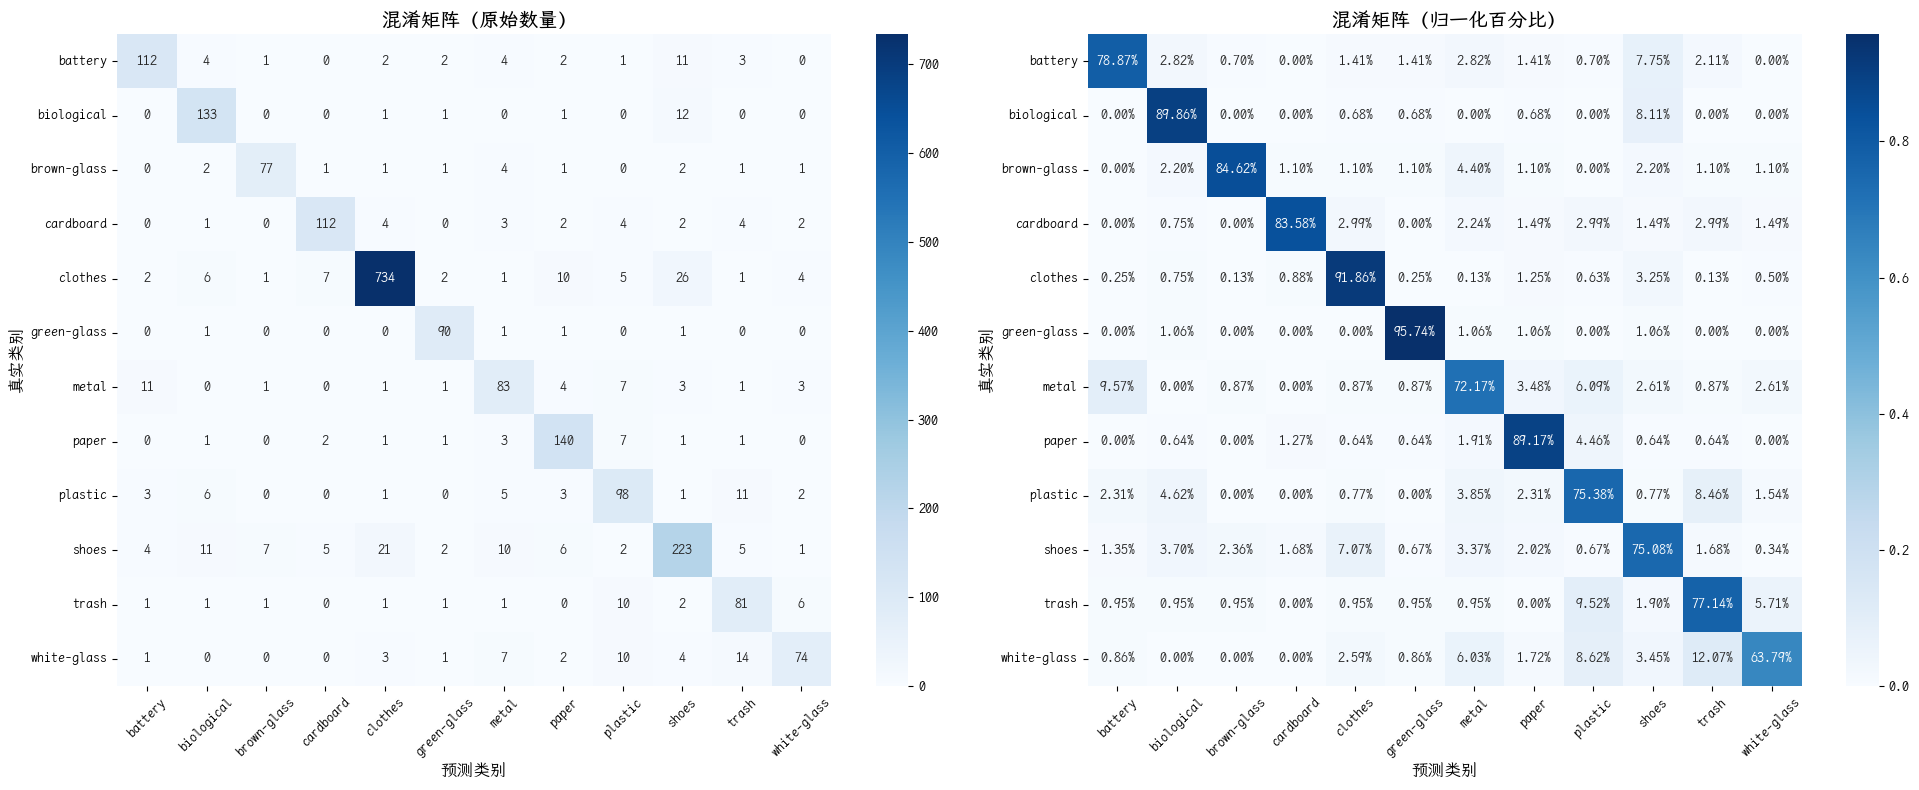

\n混淆矩阵分析:
最容易混淆的类别对:
  clothes → shoes: 26 次
\n各类别识别准确率:
  battery     : 0.789 (78.9%)
  biological  : 0.899 (89.9%)
  brown-glass : 0.846 (84.6%)
  cardboard   : 0.836 (83.6%)
  clothes     : 0.919 (91.9%)
  green-glass : 0.957 (95.7%)
  metal       : 0.722 (72.2%)
  paper       : 0.892 (89.2%)
  plastic     : 0.754 (75.4%)
  shoes       : 0.751 (75.1%)
  trash       : 0.771 (77.1%)
  white-glass : 0.638 (63.8%)
\n表现最好的类别: green-glass (95.7%)
表现最差的类别: white-glass (63.8%)


In [14]:
if val_images is not None and val_labels is not None:
    # 计算混淆矩阵
    cm = confusion_matrix(val_labels, predictions)
    
    # 创建两个子图：原始数量和归一化百分比
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # 1. 原始数量混淆矩阵
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names, ax=ax1)
    ax1.set_title('混淆矩阵 (原始数量)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('预测类别', fontsize=12)
    ax1.set_ylabel('真实类别', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    ax1.tick_params(axis='y', rotation=0)
    
    # 2. 归一化百分比混淆矩阵
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=ax2)
    ax2.set_title('混淆矩阵 (归一化百分比)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('预测类别', fontsize=12)
    ax2.set_ylabel('真实类别', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    ax2.tick_params(axis='y', rotation=0)
    
    plt.tight_layout()
    plt.show()
    
    # 打印混淆矩阵分析
    print("\\n混淆矩阵分析:")
    print("=" * 60)
    
    # 找出最容易混淆的类别对
    np.fill_diagonal(cm, 0)  # 移除对角线元素
    max_confusion_idx = np.unravel_index(np.argmax(cm), cm.shape)
    true_class, pred_class = max_confusion_idx
    max_confusion_count = cm[true_class, pred_class]
    
    print(f"最容易混淆的类别对:")
    print(f"  {class_names[true_class]} → {class_names[pred_class]}: {max_confusion_count} 次")
    
    # 恢复对角线
    cm = confusion_matrix(val_labels, predictions)
    
    # 计算每个类别的准确率
    class_accuracies = np.diag(cm) / np.sum(cm, axis=1)
    
    print(f"\\n各类别识别准确率:")
    for i, (class_name, acc) in enumerate(zip(class_names, class_accuracies)):
        print(f"  {class_name:<12}: {acc:.3f} ({acc*100:.1f}%)")
    
    # 找出表现最好和最差的类别
    best_class_idx = np.argmax(class_accuracies)
    worst_class_idx = np.argmin(class_accuracies)
    
    print(f"\\n表现最好的类别: {class_names[best_class_idx]} ({class_accuracies[best_class_idx]*100:.1f}%)")
    print(f"表现最差的类别: {class_names[worst_class_idx]} ({class_accuracies[worst_class_idx]*100:.1f}%)")

### 4. Top-K 准确率和置信度分析

Top-K 准确率:
Top-1 准确率: 0.8406 (84.06%)
Top-3 准确率: 0.9712 (97.12%)
Top-5 准确率: 0.9914 (99.14%)
\n置信度统计:
平均置信度: 0.8878
正确预测的平均置信度: 0.9225
错误预测的平均置信度: 0.7049
\n不同置信度阈值下的性能:
阈值       样本数      准确率        覆盖率       
--------------------------------------------------
0.50     2217     0.863      0.952     
0.70     1970     0.902      0.846     
0.80     1800     0.925      0.773     
0.90     1600     0.949      0.687     
0.95     1410     0.963      0.606     


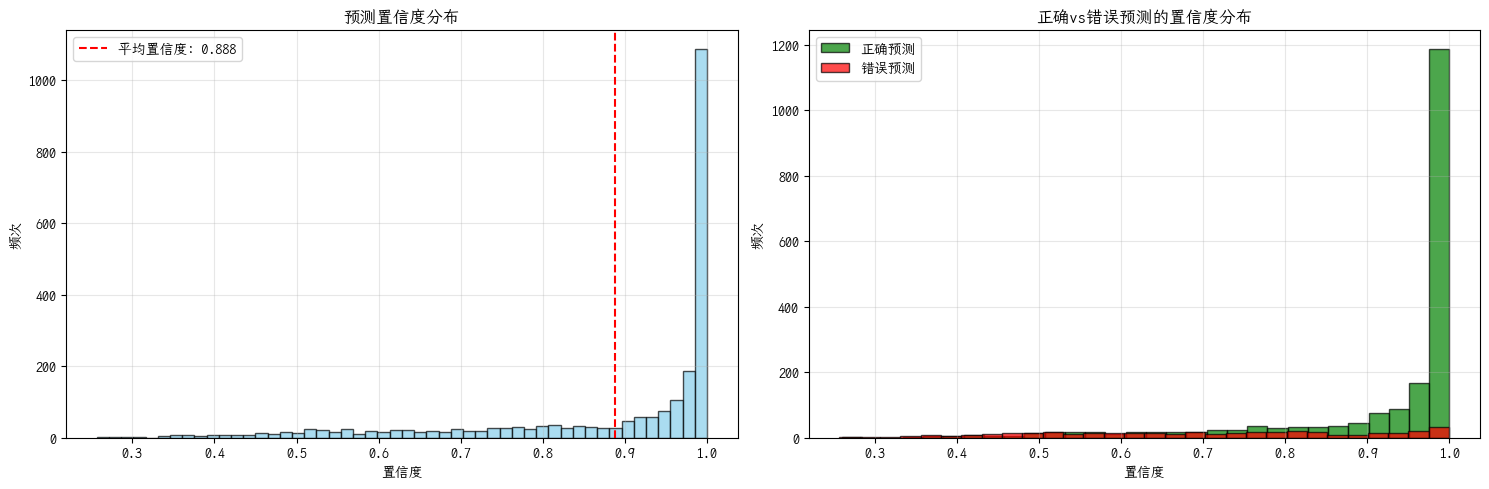

In [15]:
if val_images is not None and val_labels is not None:
    # 计算Top-K准确率
    def calculate_topk_accuracy(y_true, y_prob, k=3):
        top_k_preds = np.argsort(y_prob, axis=1)[:, -k:]
        correct = 0
        for i, true_label in enumerate(y_true):
            if true_label in top_k_preds[i]:
                correct += 1
        return correct / len(y_true)
    
    # 计算不同K值的准确率
    top1_acc = calculate_topk_accuracy(val_labels, probabilities, k=1)
    top3_acc = calculate_topk_accuracy(val_labels, probabilities, k=3)
    top5_acc = calculate_topk_accuracy(val_labels, probabilities, k=5)
    
    print("Top-K 准确率:")
    print("=" * 40)
    print(f"Top-1 准确率: {top1_acc:.4f} ({top1_acc*100:.2f}%)")
    print(f"Top-3 准确率: {top3_acc:.4f} ({top3_acc*100:.2f}%)")
    print(f"Top-5 准确率: {top5_acc:.4f} ({top5_acc*100:.2f}%)")
    
    # 置信度分析
    max_probs = np.max(probabilities, axis=1)
    correct_predictions = (predictions == val_labels)
    
    print(f"\\n置信度统计:")
    print("=" * 40)
    print(f"平均置信度: {np.mean(max_probs):.4f}")
    print(f"正确预测的平均置信度: {np.mean(max_probs[correct_predictions]):.4f}")
    print(f"错误预测的平均置信度: {np.mean(max_probs[~correct_predictions]):.4f}")
    
    # 不同置信度区间的准确率
    confidence_thresholds = [0.5, 0.7, 0.8, 0.9, 0.95]
    print(f"\\n不同置信度阈值下的性能:")
    print("=" * 50)
    print(f"{'阈值':<8} {'样本数':<8} {'准确率':<10} {'覆盖率':<10}")
    print("-" * 50)
    
    for threshold in confidence_thresholds:
        high_conf_mask = max_probs >= threshold
        if np.sum(high_conf_mask) > 0:
            high_conf_acc = np.mean(correct_predictions[high_conf_mask])
            coverage = np.mean(high_conf_mask)
            sample_count = np.sum(high_conf_mask)
            print(f"{threshold:<8.2f} {sample_count:<8} {high_conf_acc:<10.3f} {coverage:<10.3f}")
        else:
            print(f"{threshold:<8.2f} {'0':<8} {'N/A':<10} {'0.000':<10}")
    
    # 绘制置信度分布图
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # 整体置信度分布
    ax1.hist(max_probs, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.axvline(np.mean(max_probs), color='red', linestyle='--', 
                label=f'平均置信度: {np.mean(max_probs):.3f}')
    ax1.set_xlabel('置信度')
    ax1.set_ylabel('频次')
    ax1.set_title('预测置信度分布')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 正确vs错误预测的置信度分布
    ax2.hist(max_probs[correct_predictions], bins=30, alpha=0.7, 
             label='正确预测', color='green', edgecolor='black')
    ax2.hist(max_probs[~correct_predictions], bins=30, alpha=0.7, 
             label='错误预测', color='red', edgecolor='black')
    ax2.set_xlabel('置信度')
    ax2.set_ylabel('频次')
    ax2.set_title('正确vs错误预测的置信度分布')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

### 5. 错误案例分析

错误预测统计:
总预测样本数: 2328
错误预测数量: 371
错误率: 15.94%
\n各类别错误分析:
--------------------------------------------------------------------------------
真实类别         错误数      总数       错误率        主要误判为               
--------------------------------------------------------------------------------
battery      30       142      0.211      shoes(11)           
biological   15       148      0.101      shoes(12)           
brown-glass  14       91       0.154      metal(4)            
cardboard    22       134      0.164      clothes(4)          
clothes      65       799      0.081      shoes(26)           
green-glass  4        94       0.043      biological(1)       
metal        32       115      0.278      battery(11)         
paper        17       157      0.108      plastic(7)          
plastic      32       130      0.246      trash(11)           
shoes        74       297      0.249      clothes(21)         
trash        24       105      0.229      plastic(10)         
white-glass  42       116 

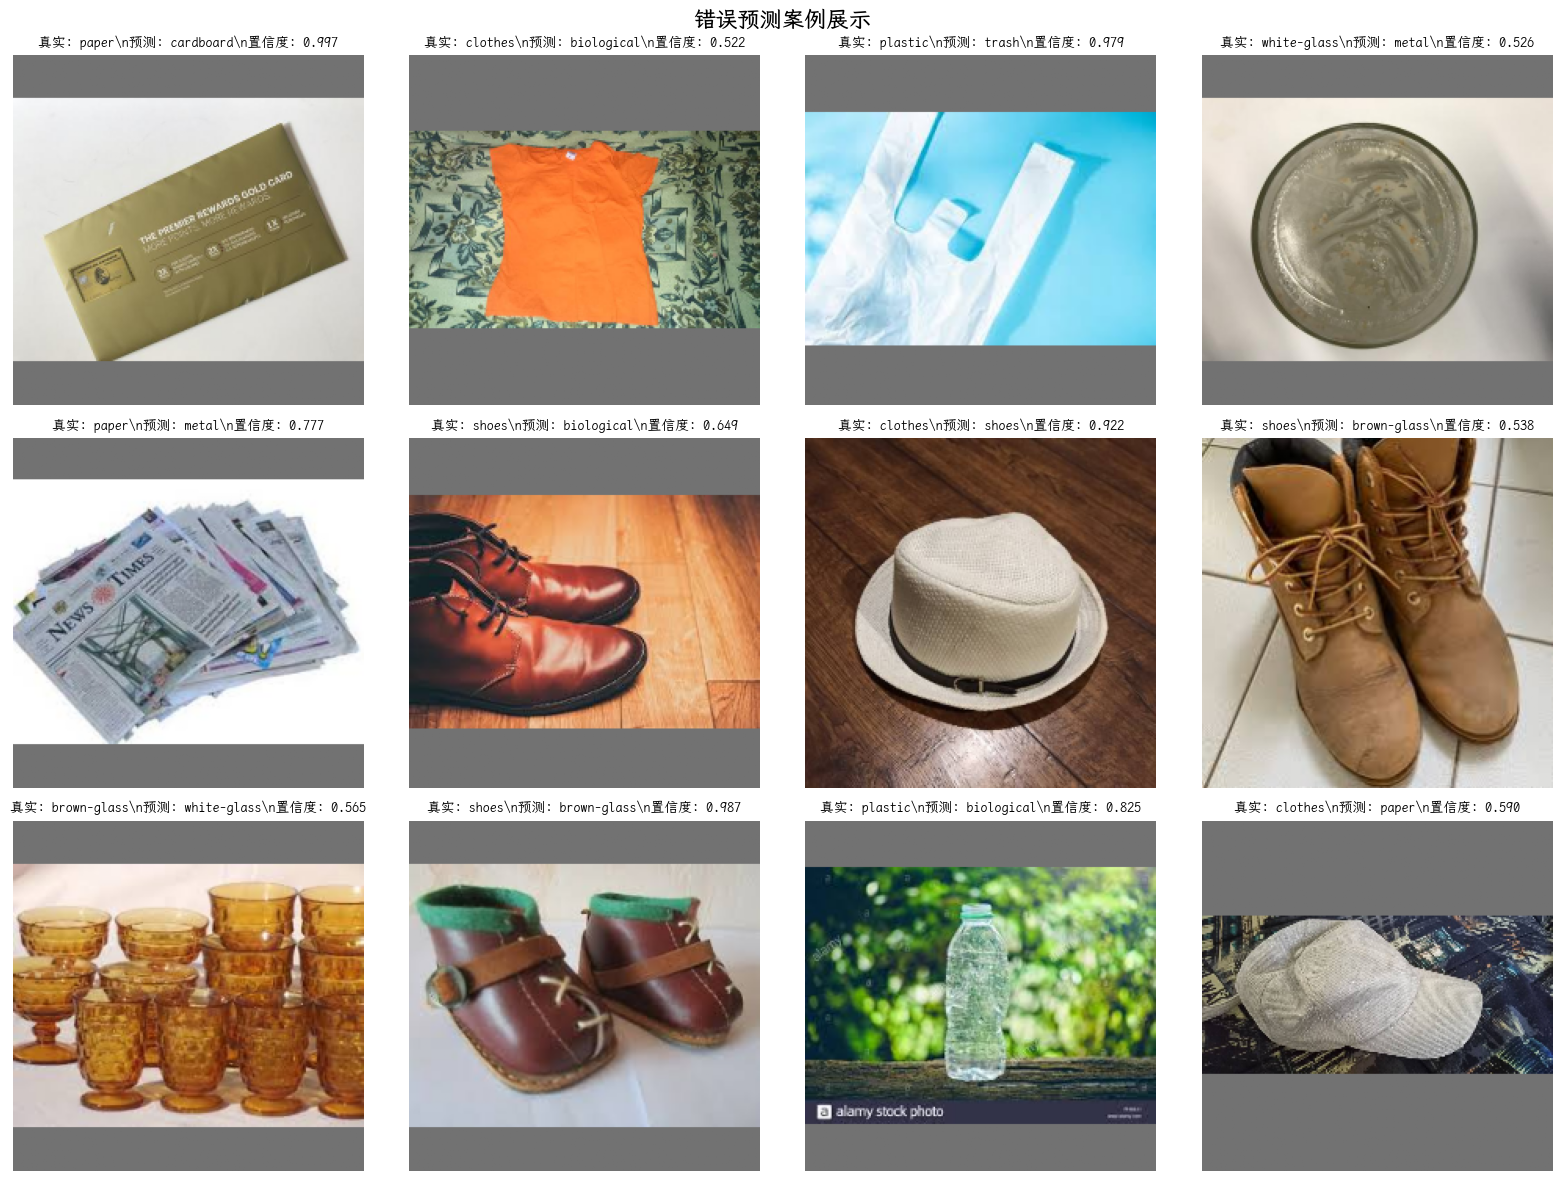

\n错误案例详细信息:
----------------------------------------------------------------------------------------------------
序号   真实类别         预测类别         置信度      Top-3预测                       
----------------------------------------------------------------------------------------------------
1    paper        cardboard    0.997    cardboard(1.00), metal(0.00), white-glass(0.00)
2    clothes      biological   0.522    biological(0.52), cardboard(0.32), clothes(0.09)
3    plastic      trash        0.979    trash(0.98), plastic(0.02), shoes(0.00)
4    white-glass  metal        0.526    metal(0.53), white-glass(0.45), shoes(0.01)
5    paper        metal        0.777    metal(0.78), battery(0.19), shoes(0.02)
6    shoes        biological   0.649    biological(0.65), shoes(0.35), battery(0.00)
7    clothes      shoes        0.922    shoes(0.92), clothes(0.08), brown-glass(0.00)
8    shoes        brown-glass  0.538    brown-glass(0.54), shoes(0.45), white-glass(0.01)
9    brown-glass  white-glass  0.

In [16]:
if val_images is not None and val_labels is not None:
    # 找出错误预测的样本
    error_indices = np.where(predictions != val_labels)[0]
    
    print(f"错误预测统计:")
    print("=" * 60)
    print(f"总预测样本数: {len(val_labels)}")
    print(f"错误预测数量: {len(error_indices)}")
    print(f"错误率: {len(error_indices)/len(val_labels)*100:.2f}%")
    
    # 分析每个类别的错误情况
    print(f"\\n各类别错误分析:")
    print("-" * 80)
    print(f"{'真实类别':<12} {'错误数':<8} {'总数':<8} {'错误率':<10} {'主要误判为':<20}")
    print("-" * 80)
    
    for true_class in range(len(class_names)):
        true_class_mask = val_labels == true_class
        true_class_predictions = predictions[true_class_mask]
        true_class_errors = np.sum(true_class_predictions != true_class)
        true_class_total = np.sum(true_class_mask)
        
        if true_class_total > 0:
            error_rate = true_class_errors / true_class_total
            
            # 找出这个类别最常被误判为什么
            wrong_preds = true_class_predictions[true_class_predictions != true_class]
            if len(wrong_preds) > 0:
                most_common_wrong = np.bincount(wrong_preds).argmax()
                most_common_wrong_name = class_names[most_common_wrong]
                most_common_count = np.sum(wrong_preds == most_common_wrong)
                main_confusion = f"{most_common_wrong_name}({most_common_count})"
            else:
                main_confusion = "无"
            
            print(f"{class_names[true_class]:<12} {true_class_errors:<8} {true_class_total:<8} "
                  f"{error_rate:<10.3f} {main_confusion:<20}")
    
    # 显示一些具体的错误案例（如果数据量不太大）
    if len(error_indices) > 0:
        print(f"\\n显示前12个错误预测案例:")
        print("=" * 60)
        
        # 随机选择一些错误案例进行可视化
        np.random.seed(42)
        sample_errors = np.random.choice(error_indices, min(12, len(error_indices)), replace=False)
        
        fig, axes = plt.subplots(3, 4, figsize=(16, 12))
        axes = axes.ravel()
        
        for i, error_idx in enumerate(sample_errors):
            if i >= 12:
                break
                
            # 显示图片
            img = val_images[error_idx]
            axes[i].imshow(img)
            
            # 获取预测信息
            true_label = val_labels[error_idx]
            pred_label = predictions[error_idx]
            confidence = max_probs[error_idx]
            
            # 设置标题
            title = f"真实: {class_names[true_label]}\\n预测: {class_names[pred_label]}\\n置信度: {confidence:.3f}"
            axes[i].set_title(title, fontsize=10)
            axes[i].axis('off')
        
        # 隐藏多余的子图
        for i in range(len(sample_errors), 12):
            axes[i].axis('off')
        
        plt.suptitle('错误预测案例展示', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # 输出这些错误案例的详细信息
        print(f"\\n错误案例详细信息:")
        print("-" * 100)
        print(f"{'序号':<4} {'真实类别':<12} {'预测类别':<12} {'置信度':<8} {'Top-3预测':<30}")
        print("-" * 100)
        
        for i, error_idx in enumerate(sample_errors):
            if i >= 12:
                break
                
            true_label = val_labels[error_idx]
            pred_label = predictions[error_idx]
            confidence = max_probs[error_idx]
            
            # 获取Top-3预测
            top3_indices = np.argsort(probabilities[error_idx])[-3:][::-1]
            top3_names = [f"{class_names[idx]}({probabilities[error_idx][idx]:.2f})" for idx in top3_indices]
            top3_str = ", ".join(top3_names)
            
            print(f"{i+1:<4} {class_names[true_label]:<12} {class_names[pred_label]:<12} "
                  f"{confidence:<8.3f} {top3_str:<30}")

### 6. 评估总结和建议

In [17]:
if val_images is not None and val_labels is not None:
    print("=" * 80)
    print("模型评估总结")
    print("=" * 80)
    
    # 模型性能总结
    print(f"\\n📊 总体性能:")
    print(f"   • 准确率: {accuracy*100:.2f}%")
    print(f"   • 宏平均F1: {f1_macro:.3f}")
    print(f"   • 加权平均F1: {f1_weighted:.3f}")
    print(f"   • Top-3准确率: {top3_acc*100:.2f}%")
    print(f"   • 平均预测置信度: {np.mean(max_probs):.3f}")
    
    # 最佳和最差类别
    print(f"\\n🏆 表现最佳类别:")
    print(f"   • {class_names[best_class_idx]}: {class_accuracies[best_class_idx]*100:.1f}%")
    
    print(f"\\n⚠️  需要改进的类别:")
    print(f"   • {class_names[worst_class_idx]}: {class_accuracies[worst_class_idx]*100:.1f}%")
    
    # 找出F1分数最低的类别
    worst_f1_idx = np.argmin(f1_per_class)
    print(f"   • F1分数最低: {class_names[worst_f1_idx]} (F1: {f1_per_class[worst_f1_idx]:.3f})")
    
    # 数据不平衡影响分析
    class_counts = [np.sum(val_labels == i) for i in range(len(class_names))]
    print(f"\\n📈 数据分布影响分析:")
    print(f"   • 样本最多的类别: {class_names[np.argmax(class_counts)]} ({max(class_counts)} 张)")
    print(f"   • 样本最少的类别: {class_names[np.argmin(class_counts)]} ({min(class_counts)} 张)")
    print(f"   • 样本比例: {max(class_counts)/min(class_counts):.1f}:1")
    
    # 改进建议
    print(f"\\n💡 改进建议:")
    
    if accuracy < 0.8:
        print(f"   • 整体准确率偏低，建议增加训练轮数或调整学习率")
    
    if f1_macro < f1_weighted - 0.05:
        print(f"   • 类别不平衡影响较大，建议使用类别权重或数据平衡技术")
    
    if np.mean(max_probs) < 0.7:
        print(f"   • 模型置信度偏低，建议增加模型复杂度或更多训练数据")
    
    low_f1_classes = [i for i, f1 in enumerate(f1_per_class) if f1 < 0.5]
    if low_f1_classes:
        print(f"   • 以下类别表现较差，建议增加训练样本:")
        for idx in low_f1_classes:
            print(f"     - {class_names[idx]} (F1: {f1_per_class[idx]:.3f})")
    
    # 保存评估结果
    evaluation_results = {
        'accuracy': float(accuracy),
        'precision_macro': float(precision_macro),
        'recall_macro': float(recall_macro), 
        'f1_macro': float(f1_macro),
        'precision_weighted': float(precision_weighted),
        'recall_weighted': float(recall_weighted),
        'f1_weighted': float(f1_weighted),
        'top3_accuracy': float(top3_acc),
        'confusion_matrix': cm.tolist(),
        'class_names': class_names,
        'per_class_metrics': {
            'precision': precision_per_class.tolist(),
            'recall': recall_per_class.tolist(),
            'f1_score': f1_per_class.tolist(),
            'support': support_per_class.tolist()
        }
    }
    
    # 可以选择保存到文件
    save_results = False  # 设置为True来保存结果
    if save_results:
        import json
        with open('evaluation_results.json', 'w', encoding='utf-8') as f:
            json.dump(evaluation_results, f, ensure_ascii=False, indent=2)
        print(f"\\n💾 评估结果已保存到 evaluation_results.json")
    
    print("\\n" + "=" * 80)
    print("评估完成! 🎉")
    print("=" * 80)

模型评估总结
\n📊 总体性能:
   • 准确率: 84.06%
   • 宏平均F1: 0.807
   • 加权平均F1: 0.841
   • Top-3准确率: 97.12%
   • 平均预测置信度: 0.888
\n🏆 表现最佳类别:
   • green-glass: 95.7%
\n⚠️  需要改进的类别:
   • white-glass: 63.8%
   • F1分数最低: metal (F1: 0.700)
\n📈 数据分布影响分析:
   • 样本最多的类别: clothes (799 张)
   • 样本最少的类别: brown-glass (91 张)
   • 样本比例: 8.8:1
\n💡 改进建议:
\n================================================================================
评估完成! 🎉
